# Imports and setup

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Set a nice visual style for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
DB_FILE = os.path.join("data", "processed", "warehouse.db")

def get_conn():
    """Creates a connection to the sqlite database."""
    # Check if file exists to prevent confusion
    if not os.path.exists(DB_FILE):
        print(f"WARNING: Database file not found at {os.path.abspath(DB_FILE)}")
    return sqlite3.connect(DB_FILE)

# Reaction by breed


Top 20 Breed-Reaction pairs:


,breed,reaction_term,count
0,Retriever - Labrador,Vomiting,24
1,Crossbred Canine/dog,Vomiting,23
2,Retriever - Labrador,"INEFFECTIVE, HEARTWORM LARVAE",21
3,Crossbred Canine/dog,"INEFFECTIVE, HEARTWORM LARVAE",18
4,Retriever - Labrador,Lack of efficacy (endoparasite) - heartworm,13
5,Chihuahua,Vomiting,11
6,Retriever - Labrador,Anorexia,11
7,Dog (unknown),Vomiting,9
8,Retriever - Labrador,"INEFFECTIVE, ASCARIDS NOS",9
9,Chihuahua,Lack of efficacy (ectoparasite) - flea,7


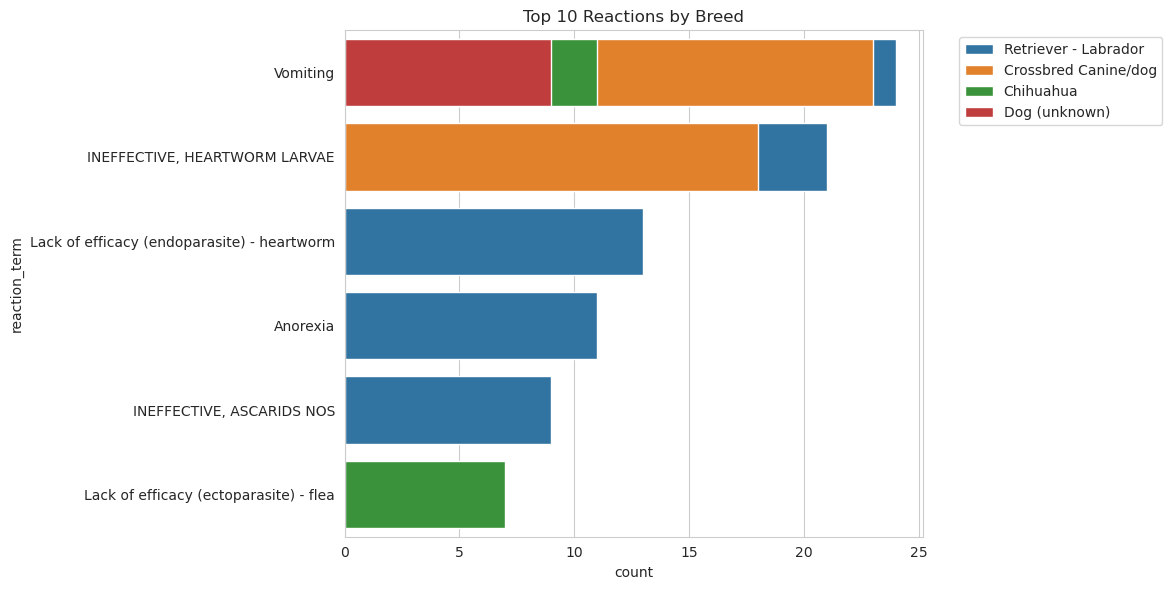

In [18]:
conn = get_conn()
query = """
SELECT e.breed, r.reaction_term, COUNT(*) as count
FROM events e
JOIN reactions r ON e.event_id = r.event_id
WHERE e.breed IS NOT NULL
GROUP BY e.breed, r.reaction_term
ORDER BY count DESC
LIMIT 20
"""
df_reactions = pd.read_sql_query(query, conn)
conn.close()

print("Top 20 Breed-Reaction pairs:")
display(df_reactions)  # 'display' renders a nice HTML table in Jupyter

# Plot top 10
plt.figure(figsize=(12, 6))
sns.barplot(data=df_reactions.head(10), x='count', y='reaction_term', hue='breed', dodge=False)
plt.title('Top 10 Reactions by Breed')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Active Ingredients

Top 10 Active Ingredients:


,active_ingredient,count
0,Spinosad,205
1,Milbemycin Oxime,203
2,Ivermectin,93
3,Pyrantel As Pamoate Salt,69
4,Moxidectin,58
5,Afoxolaner,45
6,Praziquantel,39
7,Fluralaner Chew Tablets,38
8,Pyrantel Pamoate;Sarolaner,33
9,Carprofen,33


/tmp/ipykernel_35819/2844995096.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_ingredients, x='count', y='active_ingredient', palette='viridis')


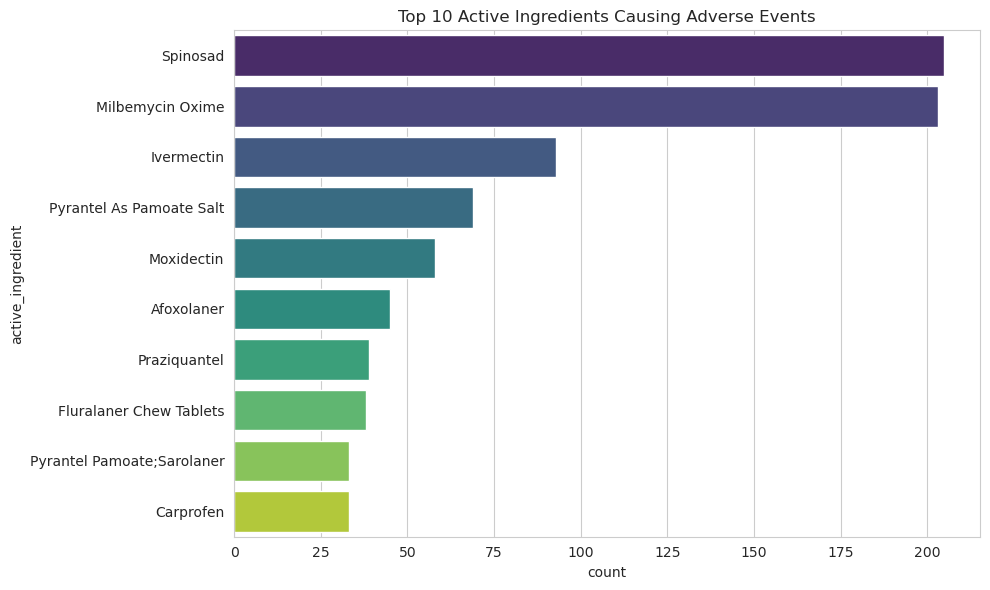

In [19]:
conn = get_conn()
query = """
SELECT active_ingredient, COUNT(*) as count
FROM drugs
WHERE active_ingredient IS NOT NULL
GROUP BY active_ingredient
ORDER BY count DESC
LIMIT 10
"""
df_ingredients = pd.read_sql_query(query, conn)
conn.close()

print("Top 10 Active Ingredients:")
display(df_ingredients)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_ingredients, x='count', y='active_ingredient', palette='viridis')
plt.title('Top 10 Active Ingredients Causing Adverse Events')
plt.tight_layout()
plt.show()

# Gender Correlation

/tmp/ipykernel_35819/3828097583.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_size, x='outcome', y='weight_kg', palette="Set2")


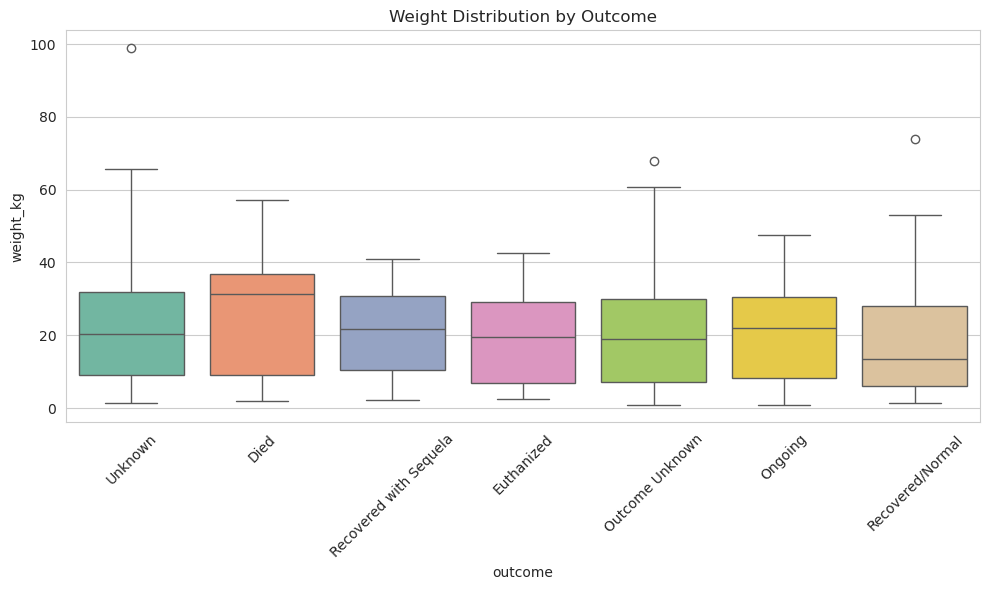

In [20]:
conn = get_conn()
query = """
SELECT weight_kg, outcome
FROM events
WHERE weight_kg IS NOT NULL AND outcome IS NOT NULL
"""
df_size = pd.read_sql_query(query, conn)
conn.close()

if df_size.empty:
    print("No data for size correlation.")
else:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_size, x='outcome', y='weight_kg', palette="Set2")
    plt.title('Weight Distribution by Outcome')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Days to reaction

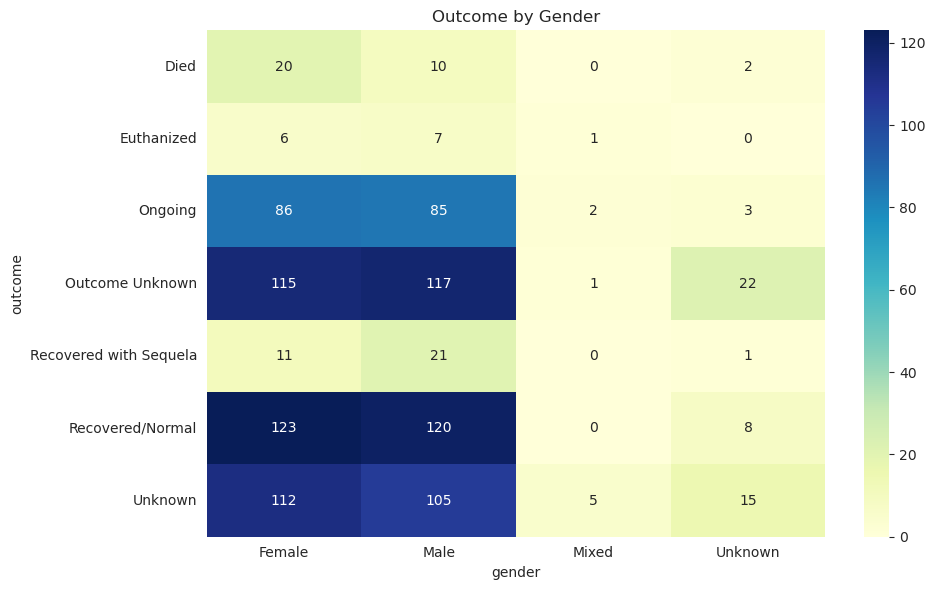

In [21]:
conn = get_conn()
query = """
SELECT gender, outcome, COUNT(*) as count
FROM events
WHERE gender IS NOT NULL AND outcome IS NOT NULL
GROUP BY gender, outcome
"""
df_gender = pd.read_sql_query(query, conn)
conn.close()

if df_gender.empty:
    print("No data for gender correlation.")
else:
    # Pivot for heatmap
    pivot = df_gender.pivot(index='outcome', columns='gender', values='count').fillna(0)

    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt='g', cmap='YlGnBu')
    plt.title('Outcome by Gender')
    plt.tight_layout()
    plt.show()

# Days to reaction

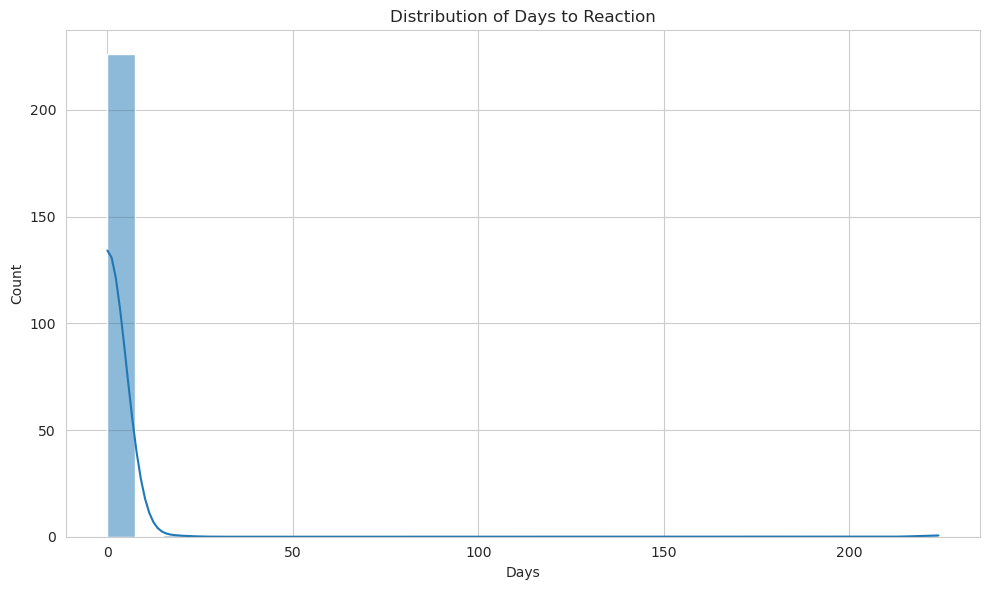

In [22]:
conn = get_conn()
query = """
SELECT days_to_reaction
FROM events
WHERE days_to_reaction IS NOT NULL
  AND days_to_reaction >= 0
  AND days_to_reaction < 365
"""
df_days = pd.read_sql_query(query, conn)
conn.close()

if df_days.empty:
    print("No data for days to reaction.")
else:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_days['days_to_reaction'], bins=30, kde=True)
    plt.title('Distribution of Days to Reaction')
    plt.xlabel('Days')
    plt.tight_layout()
    plt.show()

# Breeding Groups Analysis

Categorizing breeds (this may take a moment)...

Top Reactions by Breeding Group:


,breeding_group,reaction_term,count
806,Unknown,Vomiting,156
546,Unknown,"INEFFECTIVE, HEARTWORM LARVAE",72
607,Unknown,Lethargy (see also Central nervous system depr...,56
413,Unknown,Diarrhoea,49
588,Unknown,Lack of efficacy (ectoparasite) - flea,47
451,Unknown,Emesis,41
345,Unknown,Anorexia,39
591,Unknown,Lack of efficacy (endoparasite) - heartworm,34
592,Unknown,Lack of efficacy (endoparasite) - hookworm,29
738,Unknown,Seizure NOS,29


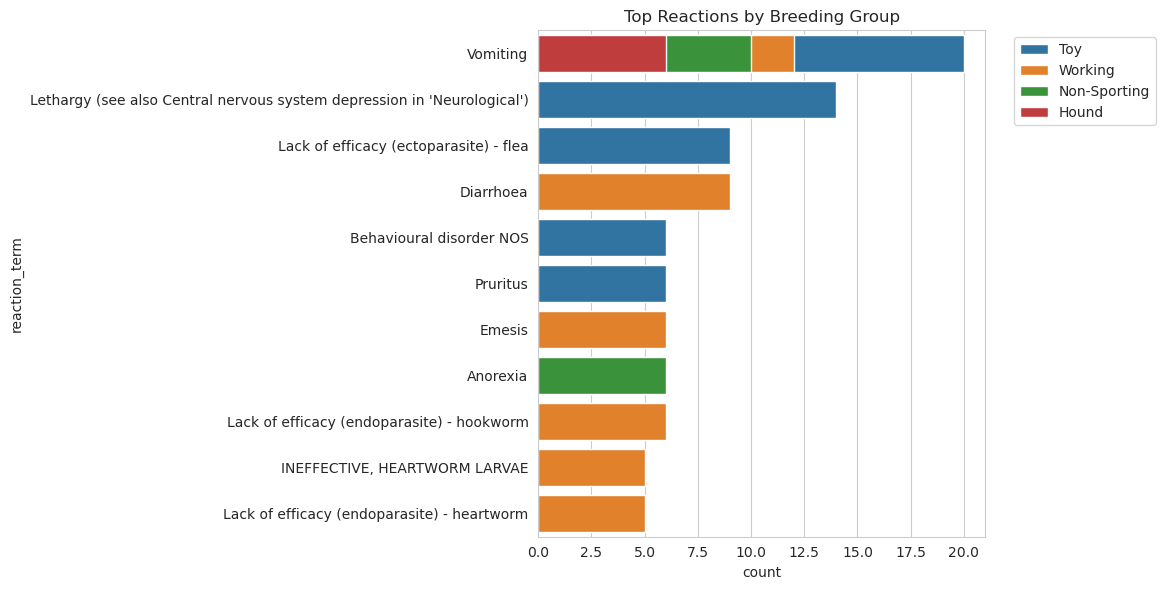

In [23]:
conn = get_conn()

# 1. Fetch Data
events_df = pd.read_sql_query("SELECT event_id, breed FROM events WHERE breed IS NOT NULL", conn)
breeds_df = pd.read_sql_query("SELECT breed_name, breeding_group FROM breed_info WHERE breeding_group IS NOT NULL", conn)
reactions_df = pd.read_sql_query("SELECT event_id, reaction_term FROM reactions", conn)
conn.close()

# 2. Define Matching Logic
# Pre-convert to lower case to speed up the loop slightly
breeds_df['breed_name_lower'] = breeds_df['breed_name'].str.lower()

def find_group(fda_breed):
    if not isinstance(fda_breed, str): return "Unknown"
    fda_breed_norm = fda_breed.lower()

    # Check against breed list
    for _, row in breeds_df.iterrows():
        if row['breed_name_lower'] in fda_breed_norm:
            return row['breeding_group']
    return "Unknown"

print("Categorizing breeds (this may take a moment)...")
events_df['breeding_group'] = events_df['breed'].apply(find_group)

# 3. Merge and Count
merged = pd.merge(events_df, reactions_df, on='event_id')
group_counts = merged.groupby(['breeding_group', 'reaction_term']).size().reset_index(name='count')
group_counts = group_counts.sort_values('count', ascending=False)

print("\nTop Reactions by Breeding Group:")
display(group_counts.head(10))

# 4. Plot
top_groups = group_counts[group_counts['breeding_group'] != 'Unknown'].head(15)

if not top_groups.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_groups, x='count', y='reaction_term', hue='breeding_group', dodge=False)
    plt.title('Top Reactions by Breeding Group')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough known breeding group data to plot.")